In [2]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from tqdm import tqdm

import easyocr

In [3]:
root = '/media/stopmosk/data/huawei/datasets/textcaps_orig'
img_root = os.path.join(root, 'train_images')

root = '/media/stopmosk/data/huawei/datasets/coco_my_ocr_13/images'
img_root = root


img_names = os.listdir(img_root)
img_names = img_names  #[:10]

In [4]:
lang = ['en']  #, 'ru']
# lang = ['en', 'de', 'es', 'fr']

reader = easyocr.Reader(lang)

In [29]:
threshold = 0.2
max_wh = 400

ocr_all = []
ocr_2_all = []
ocr_rel_all = []
#bboxes_all = []
for img_name in tqdm(img_names):
    img_full_name = os.path.join(img_root, img_name)
    im = Image.open(img_full_name)
    max_width = max_wh if im.width >= im.height else max_wh * im.width / im.height

    ocr_text = reader.readtext(
        np.asarray(im),
        #img_full_name,
        decoder='wordbeamsearch',
        batch_size=4,
        canvas_size=max_width,  # For detection
        rotation_info=[90, 180, 270],
        width_ths=0.1,
        link_threshold=0.3,
        min_size=30) #, paragraph=True)
    
    ocr_text = [item for item in ocr_text if item[2] > threshold]
    ocr_text_2 = []
    ocr_text_rel = []
    for (bbox, text, conf) in ocr_text:
        #print(bbox)
        x_s, y_s = tuple(zip(*bbox))
        uni_bbox = [
            int(min(x_s)), 
            int(min(y_s)), 
            int(max(x_s)), 
            int(max(y_s)),
            #abs(x_s[1] - x_s[2]),
            #abs(y_s[1] - y_s[2]),
        ]
        uni_bbox_rel = [
            min(x_s) / im.width, 
            min(y_s) / im.height, 
            max(x_s) / im.width, 
            max(y_s) / im.height,
            (max(x_s) - min(x_s)) / im.width, 
            (max(y_s) - min(y_s)) / im.height,
        ]
        ocr_text_2.append((uni_bbox, text, conf))
        ocr_text_rel.append((uni_bbox_rel, text, conf))
        
    ocr_all.append(ocr_text)
    ocr_2_all.append(ocr_text_2)
    ocr_rel_all.append(ocr_text_rel)

100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


In [30]:
out_all = [{
    'image_id': img_names[idx][13:-4].lstrip('0'), 
    'data': ocr_rel_all[idx]
    } for idx in range(len(ocr_2_all))]
# out_json = json.dumps(out_all)

with open(os.path.join(root, 'ocr_tags.json'), 'w') as fp:
    json.dump(out_all, fp)

# print(out_json[:2000])

In [31]:
print(out_all[0])

{'image_id': '2521', 'data': [([0.592, 0.16266666666666665, 0.762, 0.296, 0.17, 0.13333333333333333], 'ONE', 0.9982278846600977), ([0.776, 0.176, 0.946, 0.31733333333333336, 0.17, 0.14133333333333334], 'WAY', 0.7476989030838013), ([0.93, 0.42133333333333334, 0.994, 0.48533333333333334, 0.064, 0.064], 'Won', 0.5318743945083315)]}


In [32]:
def draw_box(draw, bbox, k):
    b = [[p[0]*k, p[1]*k] for p in bbox]
    draw.line(b[0] + b[1], fill=255)
    draw.line(b[1] + b[2], fill=255)
    draw.line(b[2] + b[3], fill=255)
    draw.line(b[3] + b[0], fill=255)    

1.00 ONE
0.75 WAY
0.53 Won


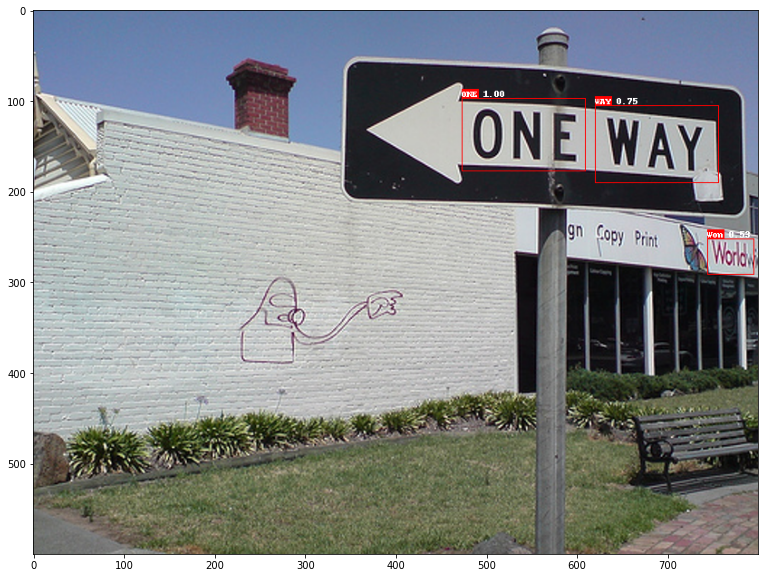

In [33]:
plt.figure(figsize=(16,10))
idx = 0
im = Image.open(os.path.join(img_root, img_names[idx]))
max_width = max_wh if im.width >= im.height else max_wh * im.width / im.height

k = max_width / im.width * 2
im = im.resize((int(im.width * k), int(im.height * k)))
draw = ImageDraw.Draw(im)

#for (bbox, text, conf) in ocr_all[idx]:
#    draw_box(draw, bbox, k)

for (bbox, text, conf) in ocr_2_all[idx]:
    b = list(np.asarray(bbox) * k)
    draw.rectangle(b, outline=255)
    b_text = [b[0], b[1]-10, b[0] + len(text)*6, b[1]]
    draw.rectangle(b_text, fill=255)
    draw.text(b_text[:2], f'{text} {conf:.2f}', stroke_width=40, stroke_fill=255)

    
plt.imshow(im)
# im.save(img_names[idx])

for (bbox, text, conf) in ocr_all[idx]:
    print(f'{conf:.2f} {text}')

# idx = 1144